In [1]:
#######################
##  Library Imports  ##
#######################
import numpy as np
import h5py as h5
import sys
import os
from numba import njit
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = 'Computer Modern Roman'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getopt
from itertools import zip_longest
import multiprocessing as mprocs
import time as TIME
from subprocess import Popen, PIPE
from matplotlib.pyplot import cm
from functions import tc, import_data, sim_data, import_data, import_spectra_data, import_post_processing_data

## Helper Functions

In [15]:
def spectra_accum(spec):
    spec_accum = np.empty_like(spec)
    spec_accum[0] = spec[0]
    for i in range(1, spec.shape[0]):
        spec_accum[i] = spec[i]
        spec_accum[i] += spec_accum[i - 1]
        
    return spec_accum

## Read in Data

In [71]:
data = "DECAY"
# data = "MAX_PALIN"
# data = "EXTRM_ENS"

num_k3_sec = 8
num_k1_sec = 1

In [72]:
if data == "DECAY":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[16,16]_T[0-5]_NU[0.000031]_CFL[0.90]_u0[DECAY_TURB_ALT]_TAG[Test-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[0.75]_TAG[Test-Test].h5".format(int(num_k3_sec), int(num_k1_sec))
elif data == "MAX_PALIN":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.001000]_CFL[0.90]_u0[MAX_PALIN]_TAG[Max-Palin-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[0.75]_TAG[Max-Palin-Test].h5".format(int(num_k3_sec), int(num_k1_sec))
elif data == "EXTRM_ENS":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.000010]_CFL[0.90]_u0[EXTRM_ENS]_TAG[Extrm-Enst-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[0.75]_TAG[Extrm-Enst-Test].h5".format(int(num_k3_sec), int(num_k1_sec))

In [73]:
# -----------------------------------------
# # --------  Read In data
# -----------------------------------------
## Read in simulation parameters
sys_vars = sim_data(in_dir)

## Read in solver data
run_data = import_data(in_dir, sys_vars)

## Read in spectra data
spec_data = import_spectra_data(in_dir, sys_vars)

## Read in post processing data
post_data = import_post_processing_data(post_file_path, sys_vars, 'file')


Preparing real space vorticity... Finished!


In [74]:
print(post_data.enst_flux_per_sec[-100, 0, :])
print(post_data.enst_flux_per_sec[-100, 1, :])
print(post_data.num_triads[0, :])
# NOTE: 8 Sectors is weird, none of the sectors match up
print("\n\nSect ID \t Enst  \t\t\t Enst \t\t\t Diff \t\t Matching\t\tAllClose\tNum Triads")
for i in range(post_data.num_sect // 2):
    print("{}/{}:\t{}\t{}\t{}\t\t{}\t\t{}\t\t{}".format(i, post_data.num_sect // 2 + i, post_data.enst_flux_per_sec[0, 0, i], post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                          post_data.enst_flux_per_sec[0, 0, i] - post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                              post_data.enst_flux_per_sec[0, 0, i] == post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i],
                                              np.allclose(post_data.enst_flux_per_sec[0, 0, i],post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i]),
                                              post_data.num_triads[0, i]))

[ -1641.84278314  43629.90475366 -24752.43196041 -10419.19801107
  -1641.84278314  43629.90475366 -24752.43196041 -10419.19801107]
[-15562.92717931  27000.34025089    434.8614445  -13595.8812742
 -15562.92717931  27000.34025089    434.8614445  -13595.8812742 ]
[254 246 254 246 254 246 254 246]


Sect ID 	 Enst  			 Enst 			 Diff 		 Matching		AllClose	Num Triads
0/4:	-1259.8490653447247	-1259.8490653447247	0.0		True		True		254
1/5:	42563.340340344876	42563.340340344876	0.0		True		True		246
2/6:	-24875.195747154386	-24875.195747154386	0.0		True		True		254
3/7:	-9903.612586097637	-9903.612586097637	0.0		True		True		246


In [75]:
print(post_data.enst_flux_per_sec[-100, 0, :])
print(post_data.enst_flux_per_sec[-100, 1, :])
print(post_data.num_triads[0, :])
# NOTE: 8 Sectors is weird, none of the sectors match up
print("\n\nSect ID \t Enst  \t\t\t Enst \t\t\t Diff \t\t Matching\t\tAllClose\tNum Triads")
for i in range(post_data.num_sect // 2):
    print("{}/{}:\t{}\t{}\t{}\t\t{}\t\t{}\t\t{}".format(i, post_data.num_sect // 2 + i, post_data.enst_flux_per_sec[0, 0, i], post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                          post_data.enst_flux_per_sec[0, 0, i] - post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                              post_data.enst_flux_per_sec[0, 0, i] == post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i],
                                              np.allclose(post_data.enst_flux_per_sec[0, 0, i],post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i]),
                                              post_data.num_triads[0, i]))

[ -1641.84278314  43629.90475366 -24752.43196041 -10419.19801107
  -1641.84278314  43629.90475366 -24752.43196041 -10419.19801107]
[-15562.92717931  27000.34025089    434.8614445  -13595.8812742
 -15562.92717931  27000.34025089    434.8614445  -13595.8812742 ]
[254 246 254 246 254 246 254 246]


Sect ID 	 Enst  			 Enst 			 Diff 		 Matching		AllClose	Num Triads
0/4:	-1259.8490653447247	-1259.8490653447247	0.0		True		True		254
1/5:	42563.340340344876	42563.340340344876	0.0		True		True		246
2/6:	-24875.195747154386	-24875.195747154386	0.0		True		True		254
3/7:	-9903.612586097637	-9903.612586097637	0.0		True		True		246


In [76]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv = np.zeros((post_data.num_sect, post_data.num_k1_sects, 16, np.amax(num_wave_vec_sec1)))
    for a in range(post_data.num_sect):
        for l in range(post_data.num_k1_sects):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1[a, l]):
                    wv[a, l, k, n] = tmp_arr[k, n]

K1_X         = 0
K1_Y         = 1
K2_X         = 2
K2_Y         = 3
K3_X         = 4
K3_Y         = 5
K1_SQR       = 6
K2_SQR       = 7
K3_SQR       = 8
K1_ANGLE     = 9
K2_ANGLE     = 10
K3_ANGLE     = 11
K1_ANGLE_NEG = 12
K2_ANGLE_NEG = 13
K3_ANGLE_NEG = 14
FLUX_TERM    = 15


## Compare sector 1 with post_data.num_sect//2 + 1
dsec  = 0
sec_0 = dsec
sec   = post_data.num_sect//2 + dsec
# print(wv[sec_0][:5, 18], wv[sec][:5, 18])

# for l in range()
# for i in range(num_wave_vec_sec1[dsec, 0]):
#     print("n: {}\t({}, {})\t({}, {})\t({}, {})\t-\t({}, {})\t({}, {})\t({}, {})\t-\t{}".format(i, 
#                                                                     wv[sec_0][K1_X, i], wv[sec_0][K1_Y, i], wv[sec_0][K2_X, i], wv[sec_0][K2_Y, i], wv[sec_0][K3_X, i], wv[sec_0][K3_Y, i],
#                                                                     wv[sec][K1_X, i], wv[sec][K1_Y, i], wv[sec][K2_X, i], wv[sec][K2_Y, i], wv[sec][K3_X, i], wv[sec][K3_Y, i], 
#                         
print(num_wave_vec_sec1)
print(wv.shape)

[[254]
 [246]
 [254]
 [246]
 [254]
 [246]
 [254]
 [246]]
(8, 1, 16, 254)


In [77]:
def neg_k_search(k, sector):
    n     = sector.shape[-1]
    x     = False
    indx  = np.inf
    neg_k = k
    
    for i in range(n):
        if np.allclose(-k, sector[:, i]):
            x     = True
            indx  = i
            neg_k = sector[:, i]
        else:
            continue

    return x, indx, neg_k

def pos_k_search(k, sector):
    n     = sector.shape[-1]
    x     = False
    indx  = np.inf
    pos_k = None
    
    for i in range(n):
        if np.allclose(k, sector[:, i]):
            x     = True
            indx  = i
            pos_k = sector[:, i]
        else:
            continue
        
    if x == False:
        pos_k = k
    return x, indx, pos_k



In [78]:
dsec = 0
sec_0 = dsec
sec = post_data.num_sect//2 + dsec
pos_present = []
neg_present = []
pos_missing = []
neg_missing = []
pos_missing_indices = []
neg_missing_indices = []

for i in range(num_wave_vec_sec1[sec_0, 1]):
    print("{} - {}".format(wv[sec_0, 1, :6, i], wv[sec, 1, :6, i]))

for l in range(post_data.num_k1_sects):
    opp_sec_list = wv[sec, l, :6, :]
    sec_0_list   = wv[sec_0, l, :6, :]
    n = num_wave_vec_sec1[sec_0, l]
    
    pos_present.append([])
    neg_present.append([])
    pos_missing.append([])
    neg_missing.append([])
    pos_missing_indices.append([])
    neg_missing_indices.append([])
    
    print("\n\nl = {}".format(l))
    print("\t\tPositive k Search\t\t\t-\t\t\tNegative k Search\t\t\t-\t\t\tNegative k Search")
    for i in range(n):
        k_sec_0   = wv[sec_0, l, :6, i]
        k_sec_opp = wv[sec, l, :6, i]
        pos_k_sear = pos_k_search(k_sec_0, opp_sec_list)
        if pos_k_sear[0] == False:
            pos_missing_indices[l].append(i)
            pos_missing[l].append(pos_k_sear[-1])

        neg_k_sear = neg_k_search(k_sec_0, opp_sec_list)
        if neg_k_sear[0] == False:
            neg_missing_indices[l].append(i)
            neg_missing[l].append(neg_k_sear[-1])

        neg_k_sear_sec = neg_k_search(k_sec_opp, sec_0_list)
#         if neg_k_sear_sec[0] == False:
#             neg_missing[l].append(neg_k_sear_sec[-1])
        pos_present[l].append(pos_k_sear)
        neg_present[l].append(neg_k_sear)
        print("{}\t-\t{}\t".format(pos_k_sear, neg_k_sear)) 
    print()
    print("Pos match: {}".format(np.all(np.asarray(np.asarray(pos_present[l])[:, 0]))))
    print("Neg match: {}".format(np.all(np.asarray(np.asarray(neg_present[l])[:, 0]))))

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
print(wv[sec_0][:6, :].shape)
print(wv[sec][:6, :].shape)
for i in range(n):
    k_dsec = wv[sec_0][:6, i]
    k_sec = wv[sec][:6, i]
    print(k_sec)

In [ ]:
print(pos_missing_indices[1])
print(wv[dsec][1][-1, pos_missing_indices[1][0]])
print(wv[dsec][1][:, pos_missing_indices[1][0]])
print(wv[dsec][1][K3_ANGLE, pos_missing_indices[1][0]])
print(theta[sec])
print(theta[dsec])
# print(np.arctan2(1, 0))
# print(np.arctan2(-1, -0))
# print(np.arctan2(-2, -4))
# print(np.arctan2(-1, -4))
print(kmax**2)

In [ ]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

for l in range(post_data.num_k1_sects):
    print("\n\nl = {}".format(l))
    for k_vec in pos_missing[l]:

        plt.figure(figsize = (13, 12))
        plt.plot(x, y, 'k--', alpha = 0.2)
        plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
        plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
        for aa in range(post_data.num_sect):
            ## Plot sectors
            plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
            plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

        ## Print missing 
#         p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#         p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#         p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
    #     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
    #     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
    #     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
        p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
        p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
        p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
        plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
        plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
        plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)
        
        plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
        plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
        plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
        print(k_vec)
        plt.show()

In [561]:
def check_list(in_list):
    for i in range(num_wave_vec_sec1[0, 0]):
        if in_list in sec_data[:6, i]:
            return True
        else:
            return False

In [562]:
sec_data = wave_vec_data_a0_l0_sec1[:6, :]
true_data = post_data.wave_vec_data_test

n = 0
for i in range(post_data.num_triads_test[0]):
    if check_list(true_data[:, i]) == True:
        continue
    else:
        n+=1
        print(i, true_data[:, i])
#     print(np.isin(sec_data[:6, i], true_data, a))
print(n)

1 [-3. -2. -2.  2. -5.  0.]
2 [-3. -1. -2.  1. -5.  0.]
3 [-3.  0. -2.  0. -5.  0.]
5 [-3.  2. -2. -2. -5.  0.]
6 [-2. -2. -3.  2. -5.  0.]
7 [-2. -1. -3.  1. -5.  0.]
8 [-2.  0. -3.  0. -5.  0.]
10 [-2.  2. -3. -2. -5.  0.]
11 [-1.  0. -4.  0. -5.  0.]
14 [-3. -1. -1. -2. -4. -3.]
15 [-3.  0. -1. -3. -4. -3.]
18 [-2. -1. -2. -2. -4. -3.]
19 [-2.  0. -2. -3. -4. -3.]
22 [-1. -1. -3. -2. -4. -3.]
25 [-3. -2. -1.  0. -4. -2.]
27 [-3.  0. -1. -2. -4. -2.]
28 [-3.  1. -1. -3. -4. -2.]
30 [-2. -2. -2.  0. -4. -2.]
32 [-2.  0. -2. -2. -4. -2.]
33 [-2.  1. -2. -3. -4. -2.]
35 [-1. -2. -3.  0. -4. -2.]
37 [-1.  0. -3. -2. -4. -2.]
38 [ 0. -2. -4.  0. -4. -2.]
40 [-3. -2. -1.  1. -4. -1.]
41 [-3. -1. -1.  0. -4. -1.]
43 [-3.  1. -1. -2. -4. -1.]
44 [-3.  2. -1. -3. -4. -1.]
46 [-2. -2. -2.  1. -4. -1.]
47 [-2. -1. -2.  0. -4. -1.]
49 [-2.  1. -2. -2. -4. -1.]
50 [-2.  2. -2. -3. -4. -1.]
52 [-1. -2. -3.  1. -4. -1.]
53 [-1. -1. -3.  0. -4. -1.]
55 [-1.  1. -3. -2. -4. -1.]
56 [ 0. -1. -4.  0. -

In [563]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[8]_KFRAC[0.75].h5') as f:
    num_wave_vec_sec2 = f["NumWavevectors"]
    wave_vec_data_a0_l0_sec2 = f["WavevectorData_a[0]_l[0]"][:, :]
    wave_vec_data_a0_l1_sec2 = f["WavevectorData_a[0]_l[1]"][:, :]    
    wave_vec_data_a1_l0_sec2 = f["WavevectorData_a[1]_l[0]"][:, :]    
    wave_vec_data_a1_l1_sec2 = f["WavevectorData_a[1]_l[1]"][:, :]  
    
print(wave_vec_data_a0_l0_sec2.shape)
print(wave_vec_data_a0_l1_sec2.shape)
print(wave_vec_data_a1_l0_sec2.shape)
print(wave_vec_data_a1_l1_sec2.shape)

print()
print("First Sec: {}\tSecond Sec: {}\tMatch: {}\tSum: {}\tSum Match: {}".format(wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1], 
                                                                                wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1], 
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] == wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1],
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] + wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1],
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] + wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1] == num_wave_vec_sec1[0, 0]))
print()
# print(wave_vec_data_a0_l0_sec2[-1, :])


print()
print()
t = np.arange(-np.pi, np.pi + 0.5, 2.0 * np.pi/2)
for i in range(2):
    for j in range(2):
        print(t[i], t[np.mod(i + j, 2)])


OSError: Unable to open file (unable to open file: name = '/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[8]_KFRAC[0.75].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# for i in range(wave_vec_data_a0_l0_sec1.shape[1]):
#     print(i, np.all(np.isin(wave_vec_data_a0_l0_sec2[:6, i], wave_vec_data_a0_l1_sec2[:6, i])))
joined_list = np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = 1)
combined = np.append(wave_vec_data_a0_l0_sec1[:6, :], joined_list, axis = 1)
np.unique(combined, axis = 0).shape
# print(wave_vec_data_a0_l0_sec1[:6, -i], np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1)[:6, -i], np.all(wave_vec_data_a0_l0_sec1[:6, -i] == np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1)[:6, -i]))
# np.all(np.isin(wave_vec_data_a0_l0_sec1, wave_vec_data_a1_l0_sec2))
# print(np.all(np.isin(wave_vec_data_a0_l0_sec1, np.append(wave_vec_data_a0_l0_sec2, wave_vec_data_a0_l1_sec2))))
# print(np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1))

## Enstorphy Flux Compare: Nonlinear Term vs Simple Sectors

In [24]:
const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

0


In [25]:
print("Test Type 0")
print((np.sum(post_data.enst_flux_per_sec[:, 0, :],axis = -1)  * const_fac_sector * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))

for i in range(1, 5):
    print()
    triad_type = i
    print("Specific Triad Type = {}".format(triad_type))
    print((post_data.enst_flux_per_sec[:, triad_type, theta]) / (post_data.enst_flux_test[:, triad_type]))

print()
print(post_data.enst_flux_per_sec[:, :, :].shape)

Test Type 0
[ -24.66306623  -23.26742828  -22.01314642  -20.88098622  -19.8550987
  -18.92230973  -18.07158142  -17.29359878  -16.580449    -15.92537003
  -15.3225516   -14.76697634  -14.25429195  -13.78070756  -13.34290914
  -12.93798997  -12.56339327  -12.21686442  -11.89641126  -11.60027059
  -11.32688017  -11.07485498  -10.84296712  -10.63012879  -10.43537781
  -10.25786538  -10.0968456    -9.95166665   -9.82176342   -9.70665124
   -9.60592082   -9.51923407   -9.44632091   -9.38697683   -9.34106128
   -9.30849679   -9.28926887   -9.28342667   -9.29108436   -9.3124234
   -9.34769564   -9.39722747   -9.4614249    -9.54078003   -9.63587878
   -9.74741034   -9.87617842  -10.02311485  -10.18929578  -10.37596112
  -10.58453793  -10.81666849  -11.07424437  -11.35944766  -11.67480133
  -12.02323113  -12.40814191  -12.83351272  -13.30401597  -13.8251682
  -14.40352247  -15.04691658  -15.76479669  -16.56864456  -17.47254931
  -18.49398385  -19.65487717  -20.98312244  -22.51474297  -24.297076

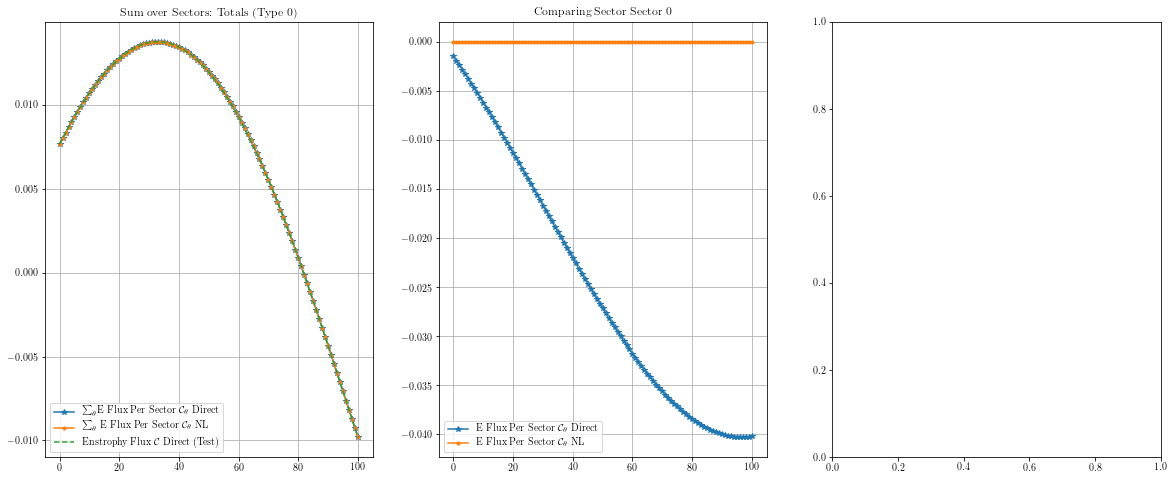

In [79]:
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 3)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac / 2, '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '.-')
ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])

theta = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac_sector * norm_fac, '*-')
ax1.plot(post_data.enst_flux_C_theta[:, theta], '.-')
ax1.set_title(r"Comparing Sector Sector {}".format(theta))
ax1.grid()
ax1.legend([r"E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$"])


ax3 = fig.add_subplot(gs[0, 2])
# ax3.plot(post_data.enst_flux_per_sec[:, 0, 0] * const_fac_sector * norm_fac, '*-')
# ax3.plot(post_data.enst_flux_per_sec[:, 0, 1] * const_fac_sector * norm_fac, '*-')
# ax3.legend([r"Bottom", r"Top"])
# print(post_data.enst_flux_per_sec[:, 0, 0] / post_data.enst_flux_per_sec[:, 0, 1])
plt.show()

#### Triad Types Compare: Sectors vs All

[-8.35521110e+10 -8.67239584e+10 -8.99086414e+10 -9.31025653e+10
 -9.63019452e+10 -9.95028081e+10 -1.02700998e+11 -1.05892181e+11
 -1.09071851e+11 -1.12235344e+11 -1.15377839e+11 -1.18494379e+11
 -1.21579879e+11 -1.24629146e+11 -1.27636891e+11 -1.30597750e+11
 -1.33506306e+11 -1.36357109e+11 -1.39144697e+11 -1.41863626e+11
 -1.44508490e+11 -1.47073950e+11 -1.49554759e+11 -1.51945792e+11
 -1.54242071e+11 -1.56438796e+11 -1.58531368e+11 -1.60515417e+11
 -1.62386828e+11 -1.64141767e+11 -1.65776698e+11 -1.67288412e+11
 -1.68674040e+11 -1.69931070e+11 -1.71057367e+11 -1.72051178e+11
 -1.72911143e+11 -1.73636306e+11 -1.74226109e+11 -1.74680401e+11
 -1.74999430e+11 -1.75183842e+11 -1.75234668e+11 -1.75153316e+11
 -1.74941558e+11 -1.74601514e+11 -1.74135632e+11 -1.73546675e+11
 -1.72837691e+11 -1.72012000e+11 -1.71073163e+11 -1.70024963e+11
 -1.68871378e+11 -1.67616557e+11 -1.66264795e+11 -1.64820508e+11
 -1.63288208e+11 -1.61672481e+11 -1.59977963e+11 -1.58209320e+11
 -1.56371224e+11 -1.54468

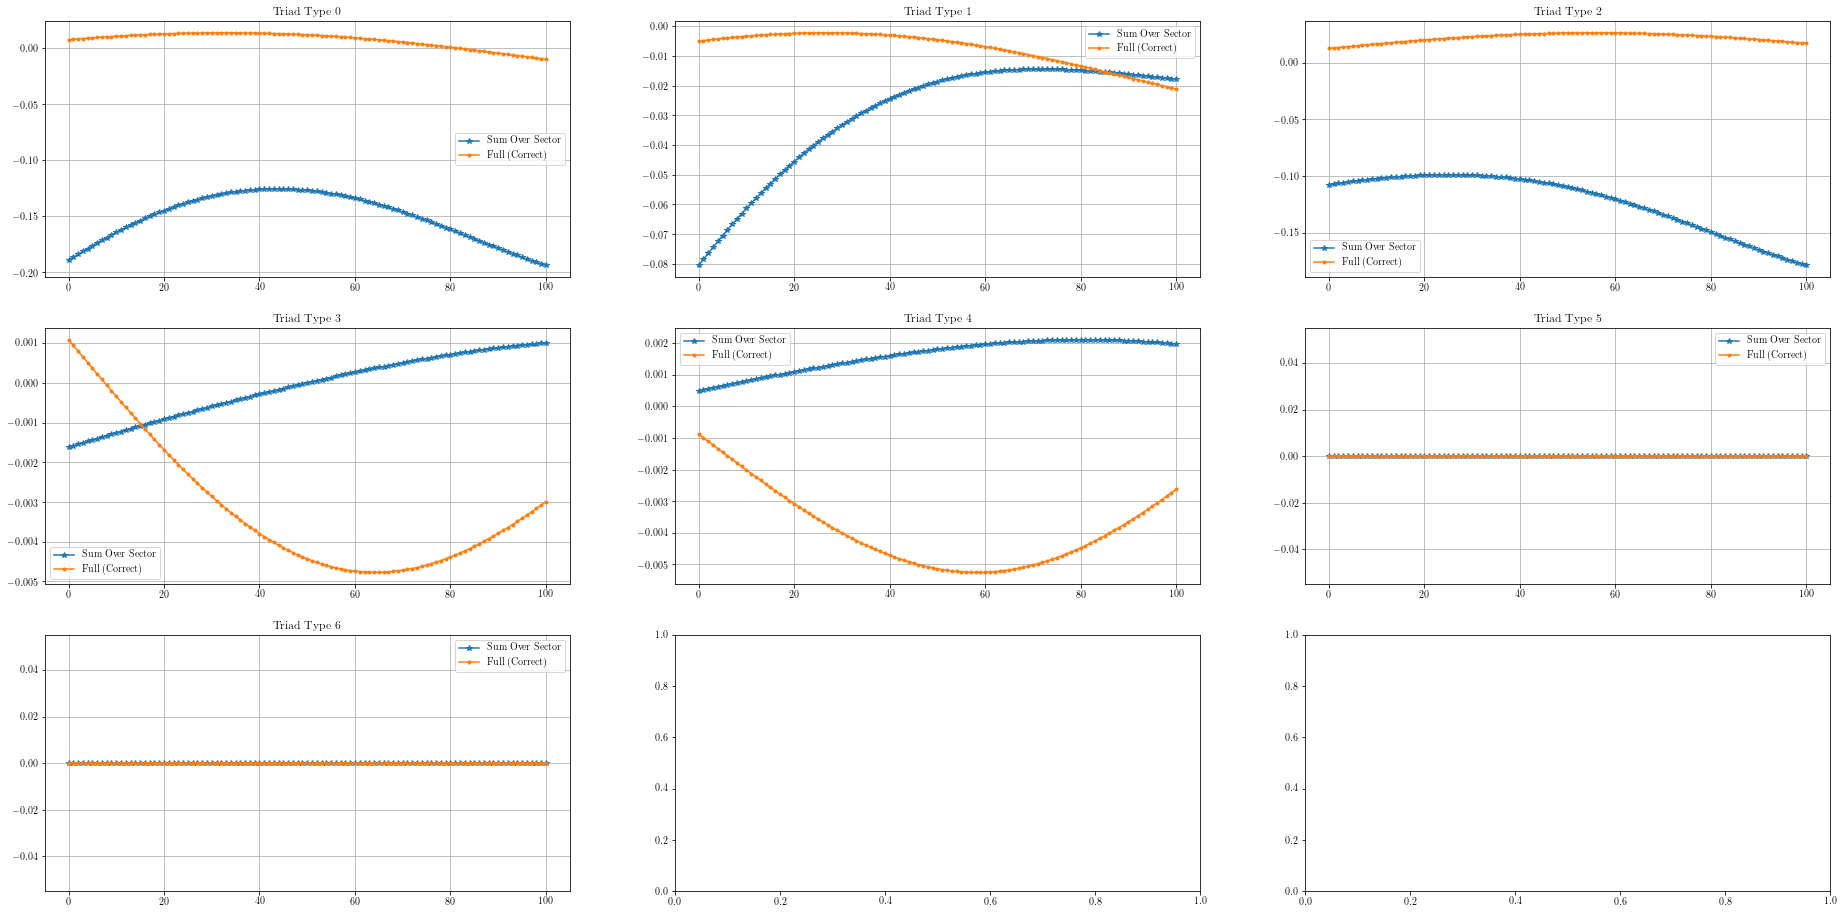

In [27]:
fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(3, 3)
ax1 = []
for i in range(3):
    for j in range(3):
        ax1.append(fig.add_subplot(gs[i, j]))
for i in range(post_data.enst_flux_per_sec.shape[1]):
    ax1[i].plot(np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac, '*-')
    ax1[i].plot(post_data.enst_flux_test[:, i] * const_fac * norm_fac, '.-')
    ax1[i].set_title(r"Triad Type {}".format(i))
#     ax1[i].set_xlim(-1, 20)
    ax1[i].legend([r"Sum Over Sector", r"Full (Correct)"])
    ax1[i].grid()
    if i == 2:
        print(1 / (np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac / post_data.enst_flux_test[:, i] * const_fac * norm_fac))
plt.show()


#### Compare Individual Sectors: Direct vs NL

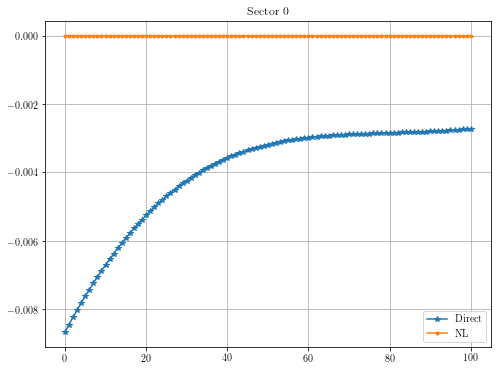

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


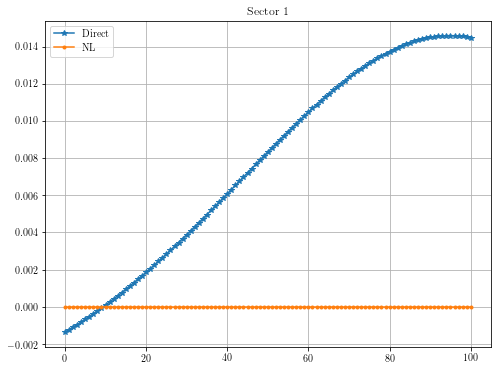

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf]


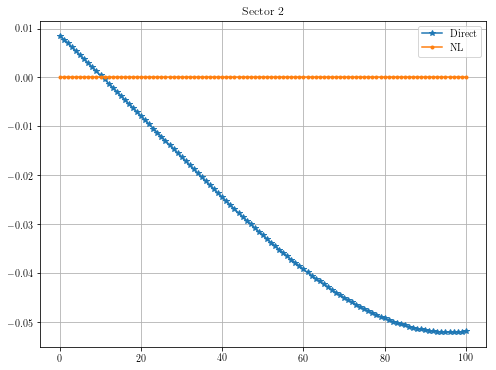

[ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


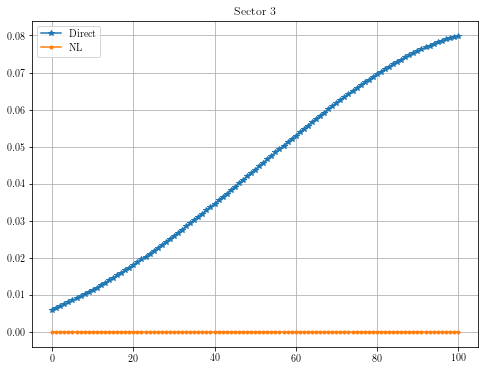

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf]


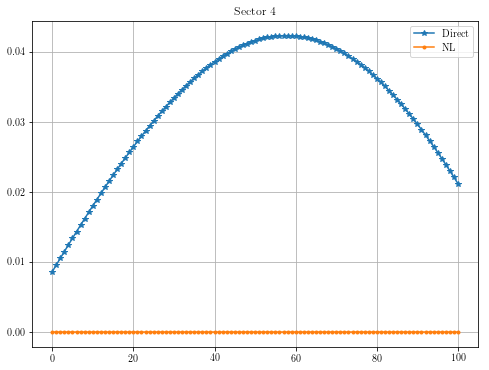

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf]


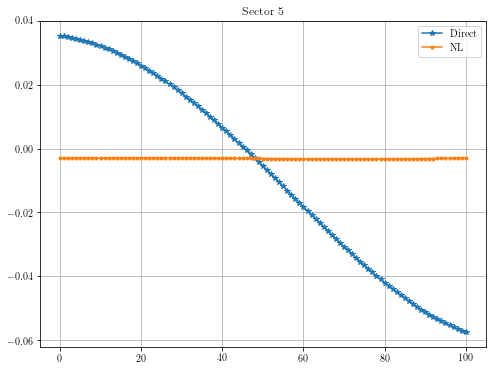

[-11.92843775 -11.88604583 -11.83267464 -11.76820398 -11.6925272
 -11.60555237 -11.50720343 -11.39742134 -11.27616506 -11.14341262
 -10.99916193 -10.84343168 -10.67626194 -10.49771485 -10.307875
 -10.10684983  -9.89476978  -9.6717884   -9.4380822   -9.19385041
  -8.93931462  -8.67471819  -8.40032559  -8.11642148  -7.82330981
  -7.52131263  -7.21076888  -6.89203305  -6.56547364  -6.23147171
  -5.89041918  -5.54271717  -5.18877427  -4.82900476  -4.46382684
  -4.09366085  -3.71892747  -3.34004604  -2.9574328   -2.57149926
  -2.18265065  -1.79128438  -1.39778862  -1.00254099  -0.60590731
  -0.20824047   0.1901206    0.58885182   0.98764482   1.38620759
   1.78426513   2.1815599    2.57785225   2.97292068   3.3665621
   3.75859194   4.14884417   4.53717135   4.92344446   5.30755285
   5.68940401   6.06892334   6.44605393   6.82075621   7.19300773
   7.5628028    7.93015217   8.29508273   8.65763722   9.01787392
   9.3758664    9.73170329  10.08548806  10.43733888  10.78738851
  11.13578424 

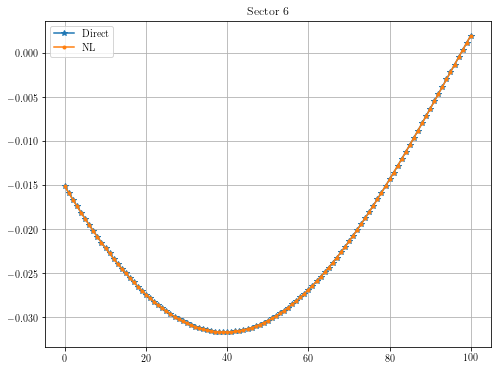

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


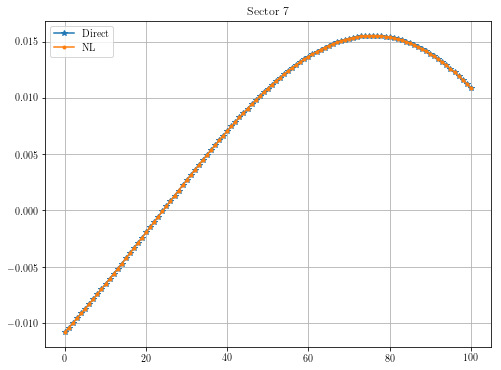

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


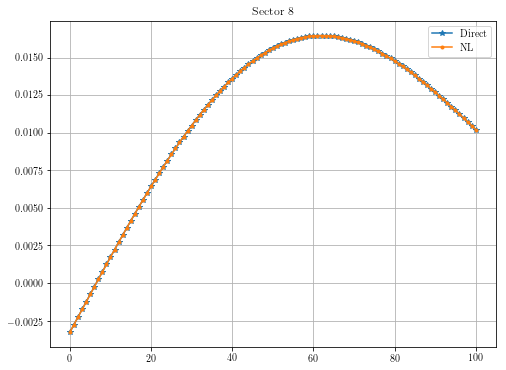

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


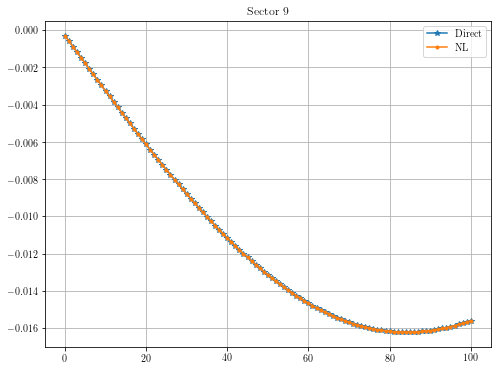

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


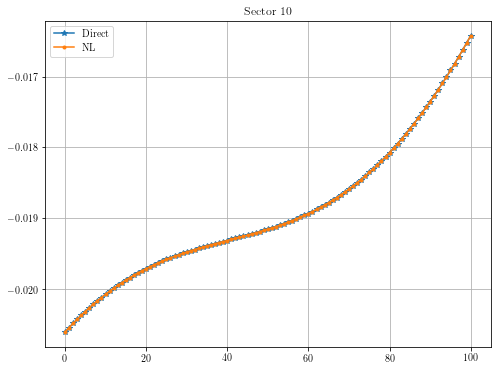

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


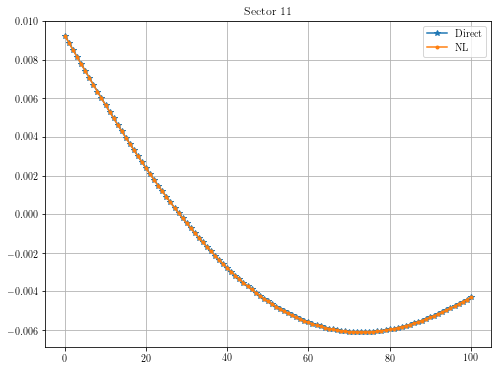

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


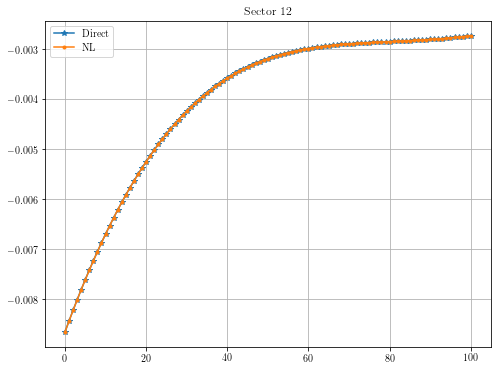

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


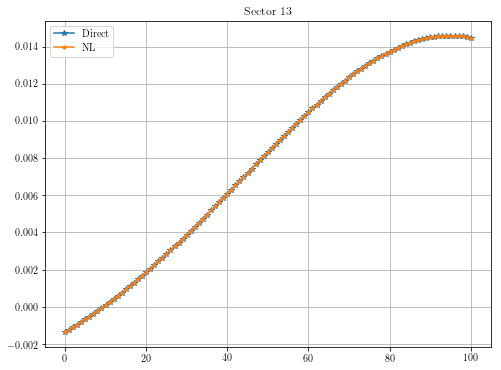

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


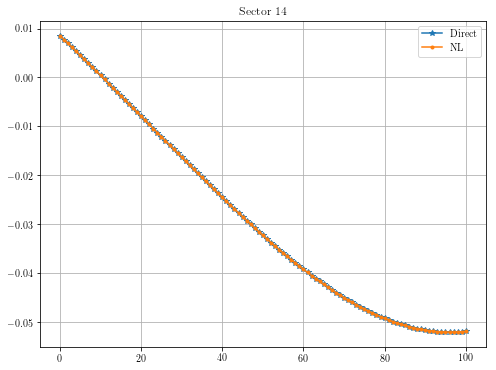

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


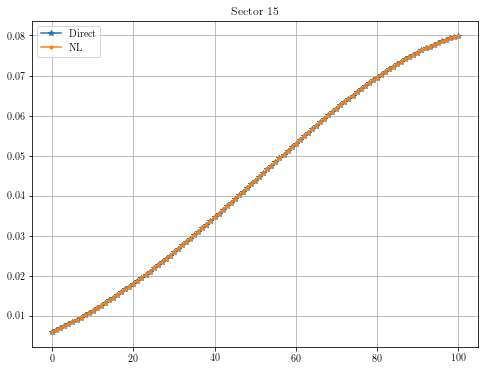

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


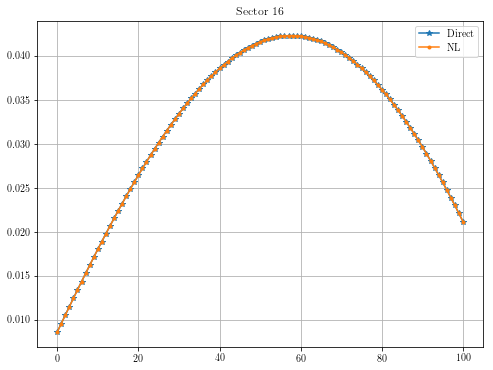

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


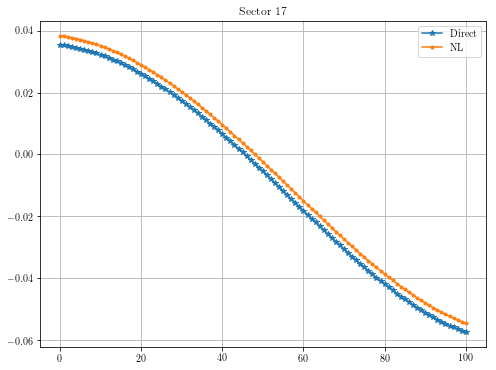

[  0.92265113   0.92239668   0.92207392   0.92168045   0.92121348
   0.92066988   0.92004608   0.91933806   0.91854134   0.91765083
   0.91666085   0.91556501   0.91435615   0.9130262    0.91156605
   0.90996547   0.90821284   0.90629499   0.90419696   0.90190164
   0.89938944   0.89663782   0.89362071   0.89030784   0.88666385
   0.88264719   0.87820873   0.87328994   0.86782057   0.86171556
   0.85487095   0.8471583    0.83841712   0.82844413   0.81697809
   0.80367755   0.78808744   0.7695877    0.74731093   0.72000554
   0.68579649   0.64174199   0.58294906   0.50063444   0.37729905
   0.17235018  -0.23475174  -1.43221313 -79.93768551   3.58928107
   2.275079     1.84633881   1.6337729    1.50686275   1.42255388
   1.36250378   1.31757685   1.28271178   1.25487808   1.23215037
   1.21324671   1.19728055   1.18361919   1.17179898   1.16147243
   1.15237392   1.14429698   1.13707864   1.13058858   1.12472134
   1.11939063   1.11452519   1.11006563   1.10596207   1.1021723
   1.098660

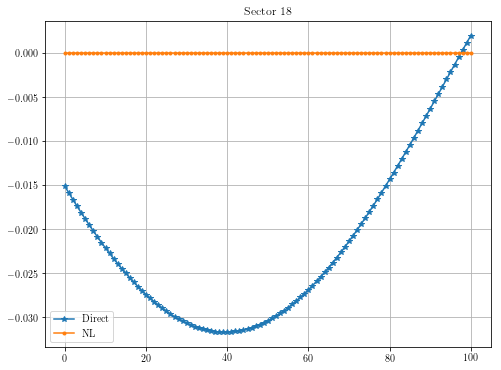

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  inf  inf  inf]


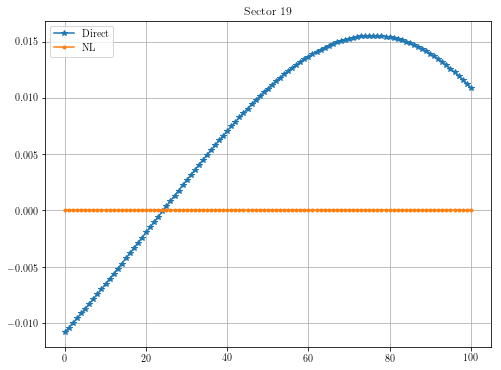

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf]


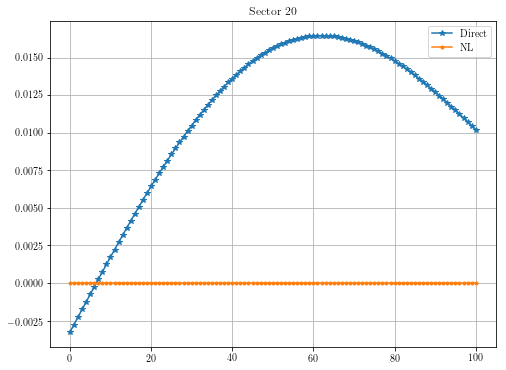

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[-inf -inf -inf -inf -inf -inf -inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf]


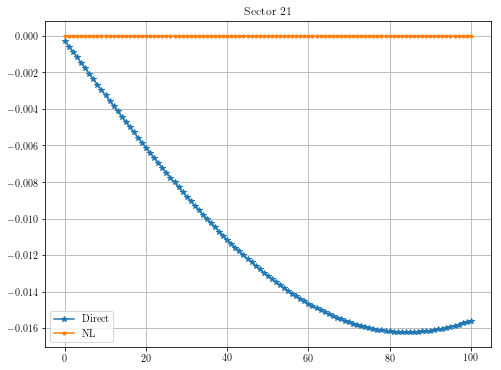

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


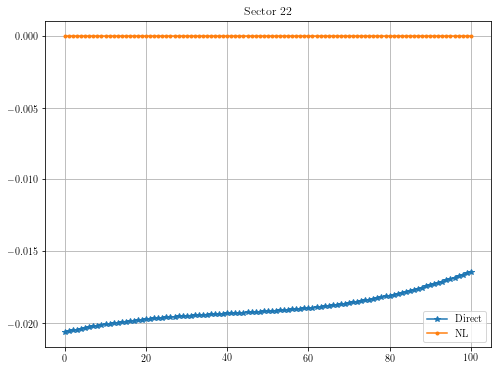

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


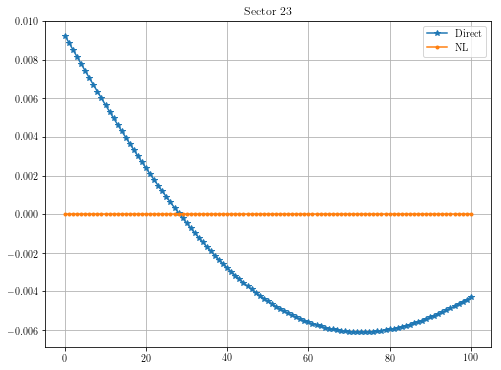

[ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [586]:
for a in range(post_data.num_sect):
    fig = plt.figure(figsize = (8, 6))
    gs  = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac, '*-')
    ax.plot(post_data.enst_flux_C_theta[:, a], '.-')
    ax.set_title(r"Sector {}".format(a))
    ax.legend([r"Direct", r"NL"])
    ax.grid()
    plt.show()
    
    print(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac / post_data.enst_flux_C_theta[:, a])

## Compare Enstorphy Flux Computed From Nonlinear Term and Directly - Ignoring Sectors

In [42]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

In [43]:
## Find the constant
print((post_data.enst_flux_test[:, 0] * const_fac * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
print()
print(const_fac)
print(norm_fac)
print(1 / (14000 * .29257143))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]

39.47841760435743
2.9802322387695312e-08
0.00024414062380790708


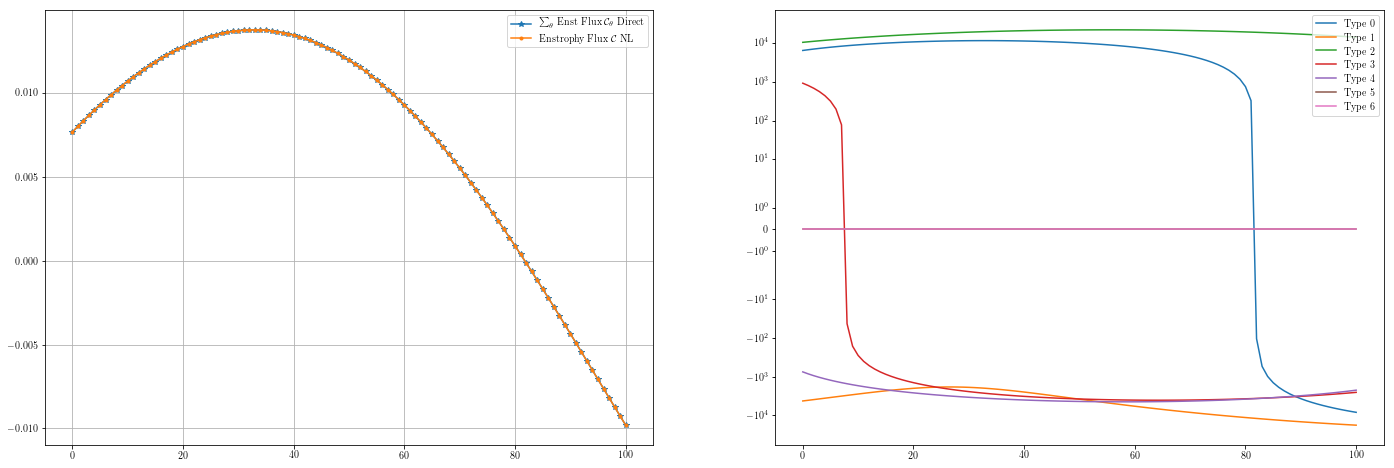

In [44]:
fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '*-')
ax1.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '.-')
# ax1.plot(post_data.enst_flux_C[:], '.-')
ax1.grid()
ax1.legend([r"$\sum_\theta$ Enst Flux $\mathcal{C}_\theta$ Direct", r"Enstrophy Flux $\mathcal{C}$ NL", r"Enstrophy Flux $\mathcal{C}$"])

ax2 = fig.add_subplot(gs[0, 1])
for i in range(post_data.triad_R_test.shape[1]):
    ax2.plot(post_data.enst_flux_test[:, i])
# ax2.set_yscale('log')
ax2.legend([r"Type {}".format(i) for i in range(post_data.triad_R_test.shape[1])])
ax2.set_yscale('symlog')
plt.show()

## Compare Both ways of computing Enstrophy Flux in C using Nonlinear term

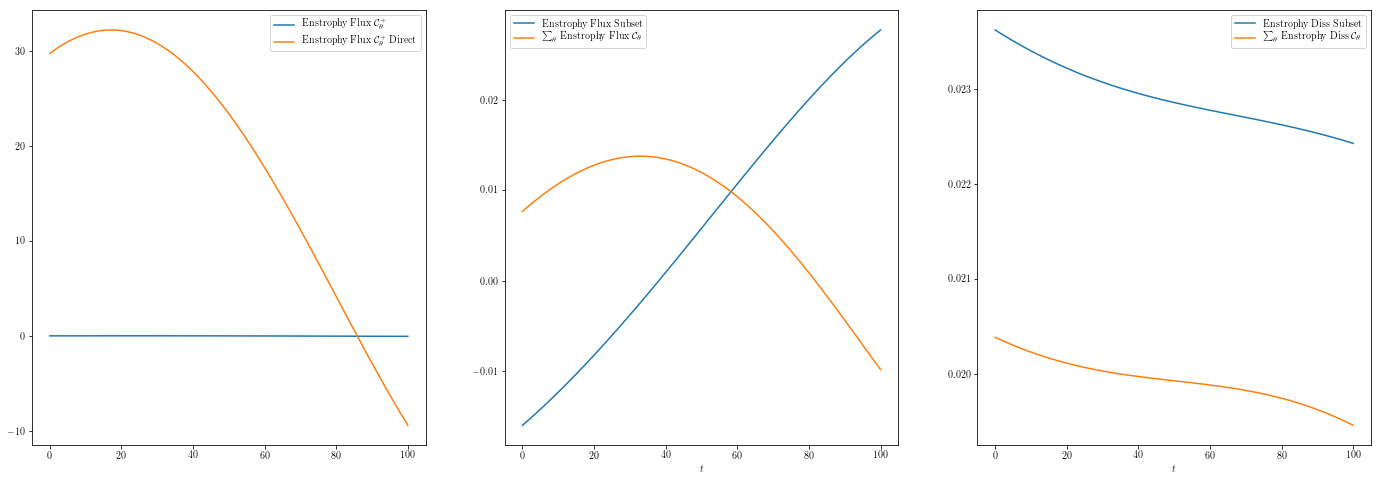

[1.15876909 1.15860161 1.15842815 1.15824883 1.15806378 1.15787315
 1.15767708 1.15747574 1.15726929 1.15705789 1.15684172 1.15662098
 1.15639585 1.15616654 1.15593325 1.15569619 1.15545558 1.15521164
 1.15496462 1.15471474 1.15446225 1.1542074  1.15395044 1.15369163
 1.15343124 1.15316954 1.1529068  1.15264331 1.15237934 1.15211518
 1.15185113 1.15158748 1.15132454 1.1510626  1.15080197 1.15054297
 1.1502859  1.15003109 1.14977884 1.14952948 1.14928334 1.14904074
 1.148802   1.14856745 1.14833743 1.14811227 1.1478923  1.14767785
 1.14746925 1.14726685 1.14707098 1.14688198 1.14670017 1.1465259
 1.14635951 1.14620132 1.14605167 1.14591091 1.14577935 1.14565734
 1.1455452  1.14544327 1.14535187 1.14527133 1.14520197 1.14514411
 1.14509808 1.14506419 1.14504275 1.14503409 1.1450385  1.14505629
 1.14508777 1.14513323 1.14519296 1.14526727 1.14535643 1.14546072
 1.14558043 1.14571582 1.14586716 1.14603471 1.14621873 1.14641948
 1.14663718 1.14687209 1.14712442 1.14739442 1.14768228 1.14798

In [55]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2
theta = int(post_data.num_sect // 2)

fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_C_theta[:, theta])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac * norm_fac)
ax1.legend([r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$", r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$ Direct"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enst_flux_C[:])
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
ax2.set_xlabel(r"$t$")
# ax2.set_xlim(-1, 20)
# ax2.set_yscale('log')
ax2.legend([r"Enstrophy Flux Subset", r"$\sum_\theta$ Enstrophy Flux $\mathcal{C}_\theta$", r"Total Enstrophy"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(post_data.enst_diss_C[:])
ax3.plot(np.sum(post_data.enst_diss_C_theta[:, :], axis = -1))
# ax3.set_yscale('log')
# ax3.set_xlim(-1, 5)
ax3.set_xlabel(r"$t$")
ax3.legend([r"Enstrophy Diss Subset", r"$\sum_\theta$ Enstrophy Diss $\mathcal{C}_\theta$", r"Total Enstrophy"])

plt.show()


print(post_data.enst_diss_C[:] / np.sum(post_data.enst_diss_C_theta[:, :], axis = -1))


## NOTE: There is a discrepency between the two methods because the way the spectrum index is computed you take the sqrt and round so some modes
## are included that aren't in C.

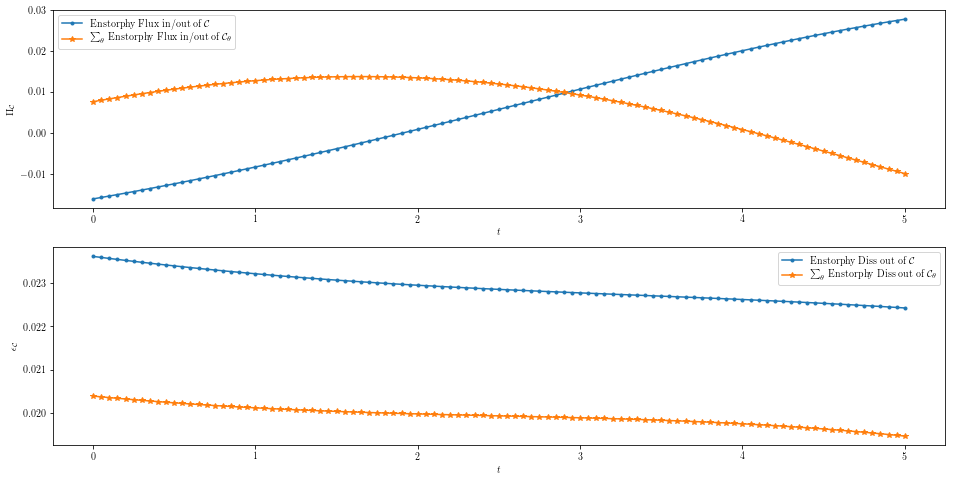

In [48]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(run_data.time, post_data.enst_flux_C[:], '.-')
ax1.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, 1:], axis = 1), '*-')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"Enstorphy Flux in/out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Flux in/out of $\mathcal{C}_\theta$"])
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(run_data.time, post_data.enst_diss_C[:], '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_diss_C_theta[:, 1:], axis = 1), '*-')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\epsilon_{\mathcal{C}}$")
ax2.legend([r"Enstorphy Diss out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Diss out of $\mathcal{C}_\theta$"])
plt.show()

## Compare Spectra Between Post & Solver 

In [50]:
 t = 50

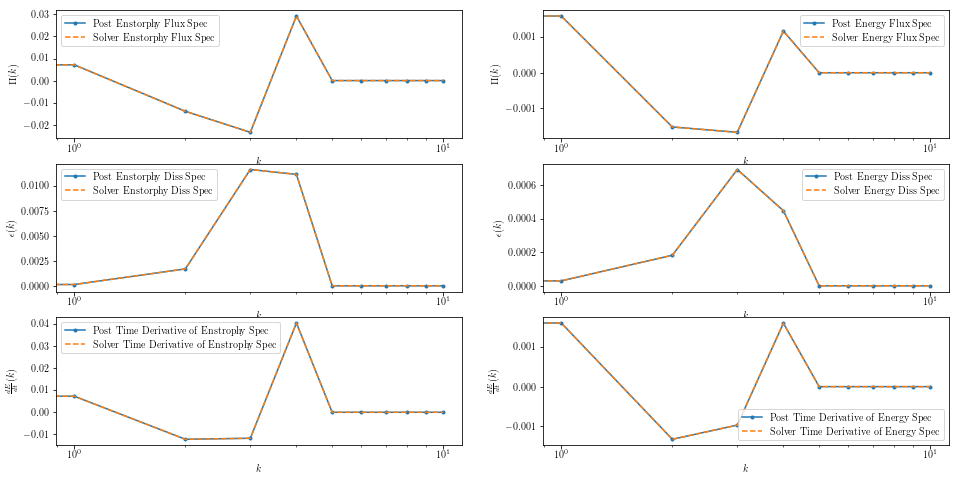

In [51]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_spec[t, 1:], '.-')
ax1.plot(spec_data.enst_flux_spectrum[t, 1:], '--')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\Pi(k)$")
ax1.set_xscale('log')
ax1.legend([r"Post Enstorphy Flux Spec", r"Solver Enstorphy Flux Spec"])
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enrg_flux_spec[t, 1:], '.-')
ax2.plot(spec_data.enrg_flux_spectrum[t, 1:], '--')
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\Pi(k)$")
ax2.set_xscale('log')
ax2.legend([r"Post Energy Flux Spec", r"Solver Energy Flux Spec"])
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(post_data.enst_diss_spec[t, 1:], '.-')
ax3.plot(spec_data.enst_diss_spectrum[t, 1:] , '--')
ax3.set_xlabel(r"$k$")
ax3.set_ylabel(r"$\epsilon(k)$")
ax3.set_xscale('log')
ax3.legend([r"Post Enstorphy Diss Spec", r"Solver Enstorphy Diss Spec"])
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(post_data.enrg_diss_spec[t, 1:], '.-')
ax4.plot(spec_data.enrg_diss_spectrum[t, 1:] , '--')
ax4.set_xlabel(r"$k$")
ax4.set_ylabel(r"$\epsilon(k)$")
ax4.set_xscale('log')
ax4.legend([r"Post Energy Diss Spec", r"Solver Energy Diss Spec"])
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(post_data.d_enst_dt_spec[t, 1:], '.-')
ax5.plot(spec_data.d_enst_dt_spectrum[t, 1:] , '--')
ax5.set_xlabel(r"$k$")
ax5.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax5.set_xscale('log')
ax5.legend([r"Post Time Derivative of Enstrophy Spec", r"Solver Time Derivative of Enstrophy Spec"])
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(post_data.d_enrg_dt_spec[t, 1:], '.-')
ax6.plot(spec_data.d_enrg_dt_spectrum[t, 1:] , '--')
ax6.set_xlabel(r"$k$")
ax6.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax6.set_xscale('log')
ax6.legend([r"Post Time Derivative of Energy Spec", r"Solver Time Derivative of Energy Spec"])
plt.show()

## Compare Enstorphy Flux in C_theta - Combing 1D and 2D Contributions

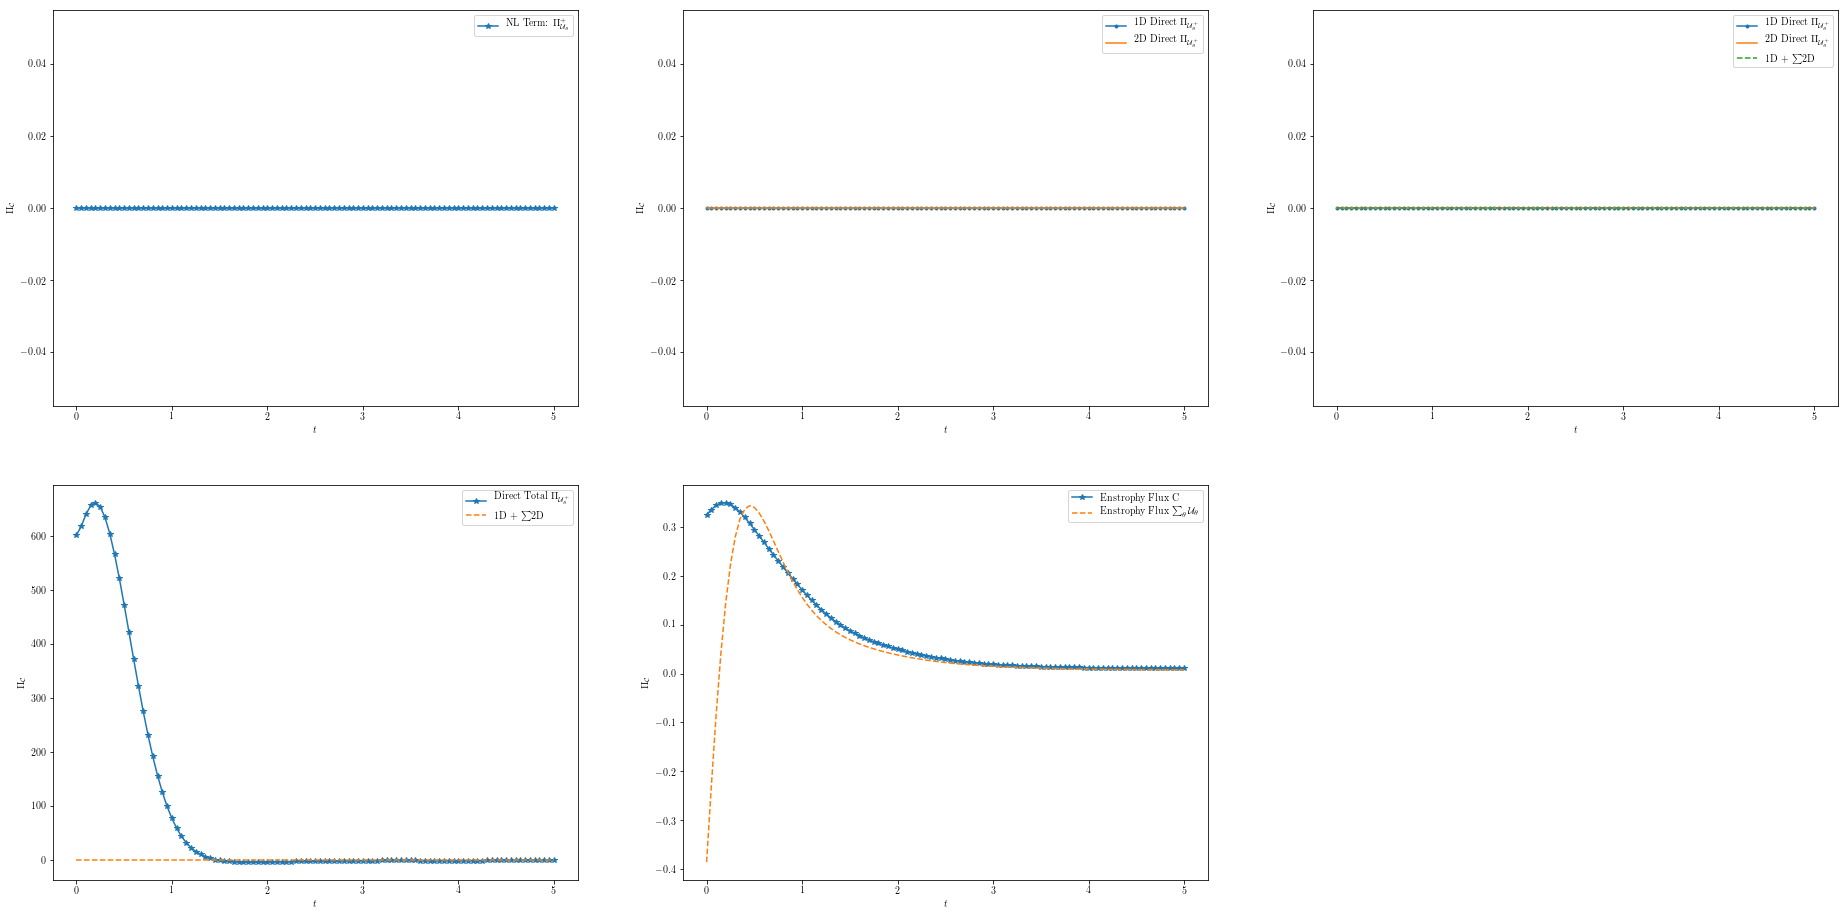

In [51]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2

theta = int(post_data.num_sect//2)

fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, theta],  '.-')
ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, -1], '*-' )
# ax1.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta], '*-') #  * norm_fac * const_fac / 10
# ax1.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
# ax1.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax1.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"NL Term: $\Pi_{\mathcal{U}_\theta}^{+}$", r"Direct Total $\Pi_{\mathcal{U}_\theta}^{+}$"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax2.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax2.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax3.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
ax3.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax3.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta] * norm_fac * const_fac / 10, '*-')
ax4.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax4.set_xlabel(r"$t$")
ax4.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax4.legend([r"Direct Total $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(run_data.time, post_data.enst_flux_C[:], '*-')
ax5.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '--')
ax5.set_xlabel(r"$t$")
ax5.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax5.legend([r"Enstrophy Flux C", r"Enstrophy Flux $\sum_\theta \mathcal{U}_\theta$"])
plt.show()

# r"$\Pi_{\mathcal{U}_\theta^{+}}$: Enstorphy Flux in/out of $\mathcal{U}_\theta^{+}$", 

[-0.00088895  0.0109422  -0.00081001 -0.00456419 -0.01642116  0.00076059
 -0.00779385  0.01451505 -0.03074954  0.05871409  0.02116911 -0.05182   ]
[ 0.          0.          0.          0.          0.          0.
 -0.00088895  0.0109422  -0.00081001 -0.00456419 -0.01642116  0.00076059
 -0.00779385  0.01451505 -0.03074954  0.05871409  0.02116911 -0.05182
 -0.00286549  0.          0.          0.          0.          0.        ]
[ 1.06478046e-02  1.09856502e-02  1.13154840e-02  1.16371252e-02
  1.19503962e-02  1.22551232e-02  1.25511356e-02  1.28382666e-02
  1.31163530e-02  1.33852354e-02  1.36447581e-02  1.38947694e-02
  1.41351216e-02  1.43656707e-02  1.45862772e-02  1.47968053e-02
  1.49971234e-02  1.51871044e-02  1.53666249e-02  1.55355662e-02
  1.56938136e-02  1.58412568e-02  1.59777900e-02  1.61033114e-02
  1.62177240e-02  1.63209349e-02  1.64128559e-02  1.64934032e-02
  1.65624973e-02  1.66200637e-02  1.66660320e-02  1.67003366e-02
  1.67229166e-02  1.67337157e-02  1.67326823e-02  1

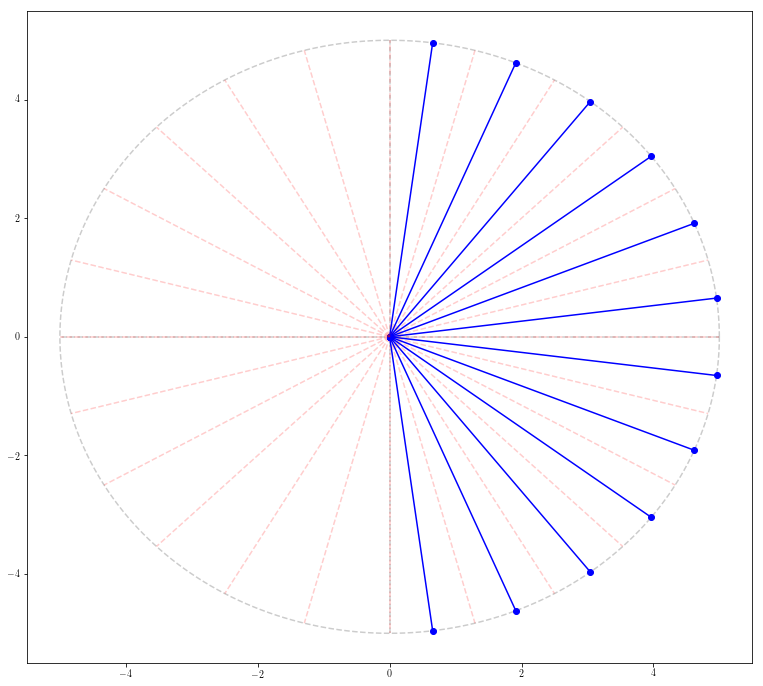

In [396]:
print(post_data.enst_flux_C_theta[-1, int(post_data.num_sect // 4):int(3 * post_data.num_sect // 4)])
print(post_data.enst_flux_C_theta[-1, :])
print(np.sum(post_data.enst_flux_C_theta[:, int(post_data.num_sect // 4):int(3 * post_data.num_sect // 4)], axis = -1))


n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

plt.figure(figsize = (13, 12))
plt.plot(x, y, 'k--', alpha = 0.2)
plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
for aa in range(post_data.num_sect):
    ## Plot sectors
    plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.1)
    plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.1)
#     if post_data.enst_flux_C_theta[-1, aa] != 0.0:
    if aa >= int(post_data.num_sect // 4) and aa < int(3 * post_data.num_sect // 4):
        plt.plot([0, R*np.cos(theta[aa])], [0, R*np.sin(theta[aa])], 'o-', alpha = 1, color = "b")
        

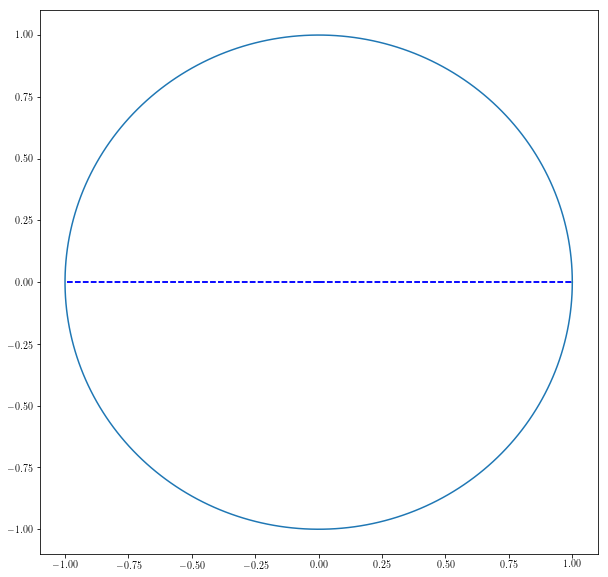

In [274]:
R = 1
angle = np.linspace(0.0, 2.0 * np.pi, 256)

x = R * np.cos(angle)
y = R * np.sin(angle)
dtheta = 2*np.pi/post_data.num_sect
fig = plt.figure(figsize = (10, 10))
plt.plot(x, y)
for i, a in enumerate(post_data.theta):
    plt.plot([0.0, R * np.cos(a - dtheta/2)], [0.0, R * np.sin(a - dtheta/2)], 'b--')
    plt.plot([0.0, R * np.cos(a + dtheta/2)], [0.0, R * np.sin(a + dtheta/2)], 'b--')    

In [38]:
Nx     = sys_vars.Nx
Ny     = sys_vars.Ny
kmax   = post_data.kmax
C_kmax = post_data.kmax_C

for k3_x in range(-Nx//2 + 1, Nx//2 + 1):
    for k3_y in range(-Nx//2 + 1, Nx//2 + 1):
        
        ## Compute polar data for k3
        k3_sqr = k3_x**2 + k3_y**2
        k3_ang = np.arctan2(k3_x, k3_y)
        k3_ang_neg = np.arctan2(-k3_x, -k3_y)
        
        if (k3_sqr > C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)
                    
        elif (k3_sqr <= C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)